In [53]:
# Install necessary packages for inference, visualization, and segmentation
!pip install inference-sdk supervision ultralytics


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quit


In [54]:
# Set up Roboflow Inference Client with your API key
from inference_sdk import InferenceHTTPClient

# Replace with your own free API key from Roboflow (see instructions below)
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="use_your_roboflow_api_key"
)


In [55]:
# Upload image using Colab file uploader
from google.colab import files
uploaded = files.upload()

# Get uploaded image path
image_path = list(uploaded.keys())[0]
print("Uploaded image:", image_path)


Saving a5e762f091d7295d615183e9057f2d51.jpg to a5e762f091d7295d615183e9057f2d51 (2).jpg
Uploaded image: a5e762f091d7295d615183e9057f2d51 (2).jpg


In [56]:
# Ask user to select region and enter clothing prompt
region = input("Select region (upper/lower): ").strip().lower()
prompt = input("Enter clothing description (e.g., 'A Hawaiian shirt'): ").strip()


Select region (upper/lower): upper
Enter clothing description (e.g., 'A Hawaiian shirt'): A Hawaiian shirt


In [57]:
# Run inference using Roboflow model
result = CLIENT.infer(image_path, model_id="main-fashion-wmyfk/1")


In [58]:
# Extract bounding boxes from detection result
def extract_bboxes(detection_results):
    predictions = detection_results["predictions"]
    bboxes = [
        [
            int(pred["x"] - pred["width"] / 2),
            int(pred["y"] - pred["height"] / 2),
            int(pred["x"] + pred["width"] / 2),
            int(pred["y"] + pred["height"] / 2)
        ]
        for pred in predictions
    ]
    return bboxes

bboxes = extract_bboxes(result)


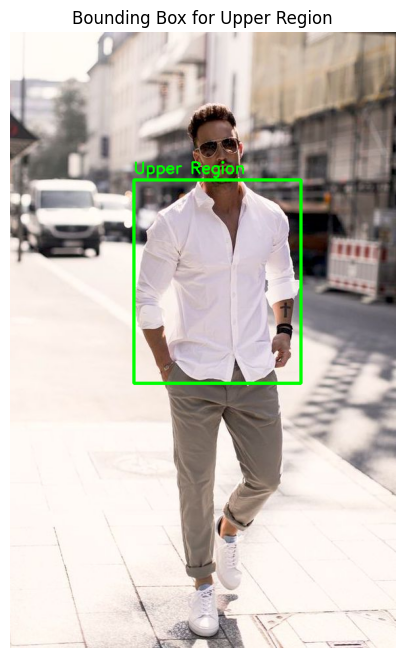

In [59]:
# Draw bounding box for selected region (Upper or Lower) on the image
import cv2
import matplotlib.pyplot as plt

def draw_selected_bbox(image_path, bbox, region_label="Selected Region"):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    x_min, y_min, x_max, y_max = bbox
    color = (0, 255, 0)  # Green box

    # Draw rectangle
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness=3)

    # Add label
    cv2.putText(image, region_label, (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Bounding Box for {region_label}")
    plt.show()

# Usage
selected_box = bboxes[0] if region == "upper" else bboxes[1]
region_label = "Upper Region" if region == "upper" else "Lower Region"
draw_selected_bbox(image_path, selected_box, region_label)


In [60]:
# Load SAM segmentation model from Ultralytics
from ultralytics import SAM
model = SAM("sam2.1_b.pt")


In [61]:
# Segment based on selected region (upper = first box, lower = second box)
selected_box = bboxes[0] if region == "upper" else bboxes[1]
segment_result = model(image_path, bboxes=selected_box)



image 1/1 /content/a5e762f091d7295d615183e9057f2d51 (2).jpg: 1024x1024 1 0, 11979.5ms
Speed: 9.4ms preprocess, 11979.5ms inference, 4.4ms postprocess per image at shape (1, 3, 1024, 1024)


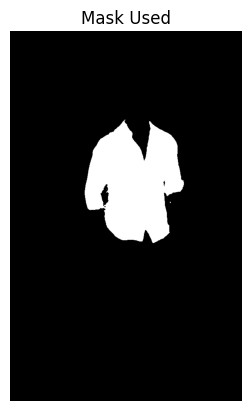

In [62]:
# Display the mask image used for inpainting
mask_img = Image.open("/content/mask_0.png")
plt.imshow(mask_img, cmap="gray")
plt.axis('off')
plt.title("Mask Used")
plt.show()

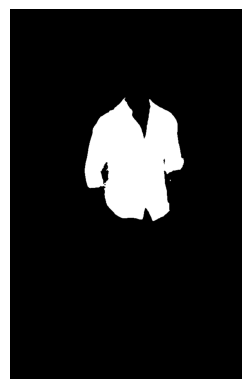

In [63]:
# Save binary mask image from segmentation result
import cv2
import numpy as np
import matplotlib.pyplot as plt

def save_binary_masks(segment_result, save_dir="masks"):
    masks = segment_result[0].masks.data.cpu().numpy()
    for i, mask in enumerate(masks):
        binary_mask = (mask > 0.5).astype(np.uint8) * 255
        cv2.imwrite(f"{save_dir}/mask_{i}.png", binary_mask)
        if i == 0:
            plt.imshow(binary_mask, cmap="gray")
            plt.axis("off")
            plt.show()

save_binary_masks(segment_result, save_dir="/content/")


In [64]:
# Inpaint using Segmind SDXL API with prompt and mask
import requests, base64
from PIL import Image
import io

def image_file_to_base64(image_path):
    with open(image_path, 'rb') as f:
        return base64.b64encode(f.read()).decode('utf-8')

api_key = "use_your_segmind_api_key"  # Replace with your Segmind key
url = "https://api.segmind.com/v1/sdxl-inpaint"

data = {
  "image": image_file_to_base64(image_path),
  "mask": image_file_to_base64("/content/mask_0.png"),
  "prompt": prompt,
  "negative_prompt": "bad quality, painting, blur",
  "samples": 1,
  "scheduler": "DDIM",
  "num_inference_steps": 25,
  "guidance_scale": 7.5,
  "seed": 12467,
  "strength": 0.9,
  "base64": False
}

headers = {'x-api-key': api_key}
response = requests.post(url, json=data, headers=headers)


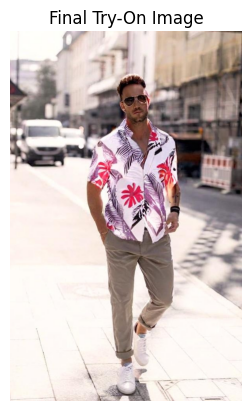

In [65]:
# Display the final inpainted image
image_bytes = response.content
image_stream = io.BytesIO(image_bytes)
image = Image.open(image_stream)

plt.imshow(image)
plt.axis('off')
plt.title("Final Try-On Image")
plt.show()
